In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Styling
plt.style.use('tdrstyle.mplstyle')

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [4]:
maxEvents = 1000
#maxEvents = 200000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (1.2, 1.4, 1.55, 1.7, 1.8, 1.98, 2.15, 2.5)
eta_bins = eta_bins[::-1]
pt_bins = (-0.50, -0.333333, -0.25, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 0.25, 0.333333, 0.50)
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

superstrip_size = 16

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def delta_phi(lhs, rhs):  # in radians
  rad = lhs - rhs
  while rad <  -np.pi:  rad += np.pi*2
  while rad >= +np.pi:  rad -= np.pi*2
  return rad

# Make EMTF image
# A m-by-n matrix has m rows and n columns
class EMTFImage(object):
  def __init__(self, superstrip_size):
    self.superstrip_size = superstrip_size

    self.sector_hits_capacity = 50

    l_lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    l_lut[1,1,4] = 0  # ME1/1a
    l_lut[1,1,1] = 0  # ME1/1b
    l_lut[1,1,2] = 1  # ME1/2
    l_lut[1,1,3] = 1  # ME1/3
    l_lut[1,2,1] = 2  # ME2/1
    l_lut[1,2,2] = 2  # ME2/2
    l_lut[1,3,1] = 3  # ME3/1
    l_lut[1,3,2] = 3  # ME3/2
    l_lut[1,4,1] = 4  # ME4/1
    l_lut[1,4,2] = 4  # ME4/2
    l_lut[2,1,2] = 1  # RE1/2
    l_lut[2,2,2] = 2  # RE2/2
    l_lut[2,3,1] = 3  # RE3/1
    l_lut[2,3,2] = 3  # RE3/2
    l_lut[2,3,3] = 3  # RE3/3
    l_lut[2,4,1] = 4  # RE4/1
    l_lut[2,4,2] = 4  # RE4/2
    l_lut[2,4,3] = 4  # RE4/3
    l_lut[3,1,1] = 0  # GE1/1
    l_lut[3,2,1] = 2  # GE2/1
    l_lut[4,1,1] = 0  # ME0
    self.l_lut = l_lut
    assert(self.l_lut.max() < nlayers)

    m_lut = np.zeros((5,5,5,2), dtype=np.int32) - 99  # (type, station, ring, fr) -> row
    m_lut[1,1,4,0] = 4  # ME1/1a (R)
    m_lut[1,1,4,1] = 3  # ME1/1a (F)
    m_lut[1,1,1,0] = 4  # ME1/1b (R)
    m_lut[1,1,1,1] = 3  # ME1/1b (F)
    m_lut[1,1,2,0] = 1  # ME1/2 (R)
    m_lut[1,1,2,1] = 0  # ME1/2 (F)
    m_lut[1,1,3,:] = 0  # ME1/3
    m_lut[1,2,1,:] = 6  # ME2/1
    m_lut[1,2,2,:] = 6  # ME2/2
    m_lut[1,3,1,:] = 7  # ME3/1
    m_lut[1,3,2,:] = 7  # ME3/2
    m_lut[1,4,1,:] = 9  # ME4/1
    m_lut[1,4,2,:] = 9  # ME4/2
    m_lut[2,1,2,:] = 2  # RE1/2
    m_lut[2,2,2,:] = 5  # RE2/2
    m_lut[2,3,1,:] = 8  # RE3/1
    m_lut[2,3,2,:] = 8  # RE3/2
    m_lut[2,3,3,:] = 8  # RE3/3
    m_lut[2,4,1,:] = 10 # RE4/1
    m_lut[2,4,2,:] = 10 # RE4/2
    m_lut[2,4,3,:] = 10 # RE4/3
    m_lut[3,1,1,:] = 2  # GE1/1
    m_lut[3,2,1,:] = 5  # GE2/1
    m_lut[4,1,1,:] = 0  # ME0
    self.m_lut = m_lut
    self.m_size = 11
    assert(self.m_lut.max() < self.m_size)

    self.n_size = 5040 // self.superstrip_size

    t_lut = np.zeros((11,7,2), dtype=np.int32) - 99  # (row,zone) -> (min theta, max theta)
    t_lut[0,0] = 4,17   # ME0
    t_lut[0,1] = 17,23  # ME0
    t_lut[1,0] = 4,17   # ME0
    t_lut[1,1] = 17,23  # ME0
    t_lut[2,1] = 17,26  # GE1/1
    t_lut[2,2] = 24,37  # GE1/1
    t_lut[2,3] = 35,45  # GE1/1
    t_lut[2,4] = 40,52  # GE1/1
    t_lut[3,0] = 4,17   # ME1/1 (F)
    t_lut[3,1] = 16,26  # ME1/1 (F)
    t_lut[3,2] = 24,37  # ME1/1 (F)
    t_lut[3,3] = 34,43  # ME1/1 (F)
    t_lut[3,4] = 41,53  # ME1/1 (F)
    t_lut[4,0] = 4,17   # ME1/1 (R)
    t_lut[4,1] = 16,26  # ME1/1 (R)
    t_lut[4,2] = 24,37  # ME1/1 (R)
    t_lut[4,3] = 34,43  # ME1/1 (R)
    t_lut[4,4] = 41,53  # ME1/1 (R)
    #
    t_lut[0,4] = 46,54  # ME1/2 (F)
    t_lut[0,5] = 52,67  # ME1/2 (F)
    t_lut[0,6] = 65,87  # ME1/2 (F)
    t_lut[1,4] = 46,54  # ME1/2 (R)
    t_lut[1,5] = 52,67  # ME1/2 (R)
    t_lut[1,6] = 65,87  # ME1/2 (R)
    t_lut[2,5] = 52,72  # RE1/2
    t_lut[2,6] = 68,84  # RE1/2
    #
    t_lut[5,0] = 7,19   # GE2/1
    t_lut[5,1] = 18,24  # GE2/1
    t_lut[5,2] = 23,35  # GE2/1
    t_lut[5,3] = 34,45  # GE2/1
    t_lut[5,4] = 40,46  # GE2/1
    t_lut[5,5] = 56,68  # RE2/2+3
    t_lut[5,6] = 64,76  # RE2/2+3
    t_lut[6,0] = 4,17   # ME2/1
    t_lut[6,1] = 16,25  # ME2/1
    t_lut[6,2] = 24,36  # ME2/1
    t_lut[6,3] = 34,43  # ME2/1
    t_lut[6,4] = 40,49  # ME2/1
    t_lut[6,5] = 52,67  # ME2/2
    t_lut[6,6] = 65,87  # ME2/2
    #
    t_lut[7,0] = 4,17   # ME3/1
    t_lut[7,1] = 16,25  # ME3/1
    t_lut[7,2] = 24,36  # ME3/1
    t_lut[7,3] = 34,40  # ME3/1
    t_lut[7,4] = 44,54  # ME3/2
    t_lut[7,5] = 52,67  # ME3/2
    t_lut[7,6] = 64,87  # ME3/2
    t_lut[8,0] = 4,20   # RE3/1
    t_lut[8,1] = 20,24  # RE3/1
    t_lut[8,2] = 24,32  # RE3/1
    t_lut[8,3] = 40,40  # RE3/2+3
    t_lut[8,4] = 40,52  # RE3/2+3
    t_lut[8,5] = 48,72  # RE3/2+3
    t_lut[8,6] = 60,84  # RE3/2+3
    #
    t_lut[9,0] = 4,17   # ME4/1
    t_lut[9,1] = 16,25  # ME4/1
    t_lut[9,2] = 24,35  # ME4/1
    t_lut[9,3] = 38,43  # ME4/2
    t_lut[9,4] = 41,54  # ME4/2
    t_lut[9,5] = 52,67  # ME4/2
    t_lut[9,6] = 64,87  # ME4/2
    t_lut[10,0] = 8,16  # RE4/1
    t_lut[10,1] = 16,28 # RE4/1
    t_lut[10,2] = 24,28 # RE4/1
    t_lut[10,3] = 36,44 # RE4/2+3
    t_lut[10,4] = 44,52 # RE4/2+3
    t_lut[10,5] = 52,64 # RE4/2+3
    t_lut[10,6] = 64,84 # RE4/2+3
    self.t_lut = t_lut

    self.zone_size = 7

    # ME1/1, ME1/2, ME2, ME3, ME4, RE1
    # RE2, RE3, RE4, GE1/1, GE2/1, ME0
    s_bend_lut =[-0.059926, -0.065415, -0.149701,  0.086035,  0.108797,  1.000000,
                  1.000000,  1.000000,  1.000000, -0.515074, -0.599277, -0.073872,]
    self.s_bend_lut = np.array(s_bend_lut, dtype=np.float32)

    s_bend_max_lut = [28, 40, 12, 20, 20, 0, 0, 0, 0, 3, 1, 18]
    self.s_bend_max_lut = np.array(s_bend_max_lut, dtype=np.float32)

  def get_layer(self, hit):
    index = (hit.type, hit.station, hit.ring)
    lay = self.l_lut[index]
    return lay

  def get_row(self, hit):
    index = (hit.type, hit.station, hit.ring, hit.fr)
    m = self.m_lut[index]
    assert(m < self.m_size)
    return m

  def get_col(self, hit):
    hit_phi = np.asarray(hit.emtf_phi, dtype=np.int32)
    n = hit_phi // self.superstrip_size
    assert(n < self.n_size)
    return n

  def get_zones(self, hit):
    m = self.get_row(hit)
    t = self.t_lut[m]
    hit_theta = np.asarray(hit.emtf_theta, dtype=np.int32)
    zones = np.logical_and(t[:,0] <= hit_theta, hit_theta <= t[:,1])
    zones = np.where(zones)[0]
    assert((zones < self.zone_size).all())
    return zones

  def get_chn_bend(self, hit):
    if hit.type == kCSC:
      bend = hit.bend
      bend *= hit.endcap
    elif hit.type == kGEM:
      bend = hit.bend
      bend *= hit.endcap
    else:
      bend = hit.bend
    lay = self.get_layer(hit)
    #s = self.s_bend_lut[lay]
    #bend *= s
    s = self.s_bend_max_lut[lay]
    if s == 0:
      bend = 0.5
    else:
      bend = np.clip(float(bend), -s, s)
      bend = 0.5 + bend/(2 * s)
    return bend

  def get_chn_theta(self, hit):
    theta = np.clip(float(hit.emtf_theta), 4., 86.)
    theta = (theta - 3.)/83.
    return theta

  def get_chn_mphi(self, hit):
    n = self.get_col(hit)
    mphi = float(hit.emtf_phi) - (n * self.superstrip_size)
    mphi /= self.superstrip_size
    return mphi

  def get_chn(self, hit):
    chn = (self.get_chn_bend(hit),
           self.get_chn_theta(hit),
           self.get_chn_mphi(hit))
    chn = np.asarray(chn, dtype=np.float32)
    assert((0.0 <= chn).all())
    assert((chn <= 1.0).all())
    return chn

  def is_intime(self, hit):
    if hit.type == kCSC:
      return hit.bx == -1 or hit.bx == 0
    else:
      return hit.bx == 0

  def __call__(self, hits):
    amap = {}
    for ihit, hit in enumerate(hits):
      if self.is_intime(hit):
        m = self.get_row(hit)
        n = self.get_col(hit)
        zones = self.get_zones(hit)
        for z in zones:
          m_z = m + (z * self.m_size)
          amap.setdefault((m_z,n), []).append(hit)

    image_pixels = np.zeros((self.sector_hits_capacity,2), dtype=np.int32) - 99
    image_channels = np.zeros((self.sector_hits_capacity,3), dtype=np.float32) + np.nan

    i = 0
    for k, v in amap.iteritems():
      if i == self.sector_hits_capacity:
        break
      (m,n) = k
      hits_mn = v
      h = hits_mn[0]  # arbitrarily pick the first hit
      chn = self.get_chn(h)

      image_pixels[i] = (m,n)
      image_channels[i] = chn
      i += 1

    return image_pixels, image_channels

make_emtf_image = EMTFImage(superstrip_size=superstrip_size)


# Assign EMTF label
class EMTFLabel(object):
  def __init__(self):
    self.pt_bins = np.linspace(-0.525, 0.525, num=22)
    self.eta_bins = eta_bins
    self.phi_bins = np.linspace(-40, 40, num=129)  # uGMT uses 360./576

  def find_pt_bin(self, part):
    pt = np.true_divide(part.q, part.pt)
    ipt = np.digitize((pt,), self.pt_bins[1:])[0]  # skip lowest edge
    ipt = np.clip(ipt, 0, len(self.pt_bins)-2)
    return ipt

  def find_sector_phi(self, glob, sector):  # glob in deg, sector in [1,6]
    # sector 1 starts at 15 deg
    loc = glob - 15. - (60. * (sector-1))
    # but here I'm assuming sector 1 centers at 40 deg
    center = 40.
    dphi = delta_phi(loc, center)
    return dphi

  def find_phi_bin(self, part, sector):
    phi = self.find_sector_phi(np.rad2deg(part.phi), (sector%6)+1)
    iphi = np.digitize((phi,), self.phi_bins[1:])[0]  # skip lowest edge
    iphi = np.clip(iphi, 0, len(self.phi_bins)-2)
    return iphi

  def find_eta_bin(self, part):
    eta = abs(part.eta)
    ieta = np.digitize((eta,), self.eta_bins[1:])[0]  # skip lowest edge
    ieta = np.clip(ieta, 0, len(self.eta_bins)-2)
    return ieta

  def __call__(self, part, sector):
    label = (self.find_pt_bin(part),
             self.find_phi_bin(part, sector),
             self.find_eta_bin(part))
    label = np.asarray(label, dtype=np.int32)
    return label

assign_emtf_label = EMTFLabel()

In [5]:
def process(verbose=1):
  tree = load_pgun()
  
  out_image_pixels = []
  out_image_channels = []
  out_labels = []
  out_parameters = []

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break

    if verbose and (ievt % 1000 == 0):  print("Processing event: {0}".format(ievt))

    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue

    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue

    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)

    # Find the best sector
    sector_cnt_array = np.zeros((12,), dtype=np.int32)
    sector_hits_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_hits_array.shape):
      sector_hits_array[ind] = []

    for ihit, hit in enumerate(evt.hits):
      #print(".. hit  {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11}".format(ihit, hit.bx, hit.type, hit.station, hit.ring, hit.sector, hit.fr, hit.sim_phi, hit.sim_theta, hit.time, hit.sim_tp1, hit.sim_tp2))

      assert(hit.emtf_phi < 5040)  # 84*60
      endsec = find_endsec(hit.endcap, hit.sector)
      sector_cnt_array[endsec] += 1
      sector_hits_array[endsec].append(hit)

    # Get the best sector hits
    best_sector = np.argmax(sector_cnt_array)
    sector_hits = sector_hits_array[best_sector]

    # The workhorse
    image_pixels, image_channels = make_emtf_image(sector_hits)
    out_image_pixels.append(image_pixels)
    out_image_channels.append(image_channels)

    labels = assign_emtf_label(part, best_sector)
    out_labels.append(labels)

    parameters = np.asarray((np.true_divide(part.q, part.pt), part.phi, part.eta), dtype=np.float32)
    out_parameters.append(parameters)

  outs = (np.asarray(out_image_pixels, dtype=np.int32), 
          np.asarray(out_image_channels, dtype=np.float32),
          np.asarray(out_labels, dtype=np.int32),
          np.asarray(out_parameters, dtype=np.float32),)
  return outs

In [6]:
image_pixels, image_channels, labels, parameters = process()
print image_pixels.shape, image_pixels[0]
print image_channels.shape, image_channels[0]
print labels.shape, labels[0]
print parameters.shape, parameters[0]

outfile = 'histos_tbe.npz'
np.savez_compressed(outfile, image_pixels=image_pixels, image_channels=image_channels, labels=labels, parameters=parameters)

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Processing event: 0
(887, 50, 2) [[ 19 223]
 [  6 221]
 [ 13 195]
 [ 17 221]
 [  8 223]
 [ 14 198]
 [ 11 192]
 [  9 222]
 [  7 223]
 [ 18 223]
 [  5 220]
 [ 16 220]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]
 [-99 -99]]
(887, 50, 3) [[0.         0.20481928 0.        ]
 [0.9166667  0.16867469 0.625     ]
 [0.5535714  0.22891566 0.4375    ]
 [0.9166667  0.16867469 0.625     ]
 [0.         0.20481928 0.        ]
 [0.71428573 0.20481928 0.1875    ]
 [0.8035714  0.22891566 0.125     ]
 [0.5        0.14457831 0.875     ]
 [0.5        0.15662651 0.        ]
 [0.5      

In [7]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,5)
#mpl.rcParams['axes.labelpad'] = 0
#mpl.rcParams['axes.labelsize'] = 0
#mpl.rcParams['xtick.labelsize'] = 0
#mpl.rcParams['ytick.labelsize'] = 0

In [8]:
def imaging(pixels, channels, superstrip_size):
  zone_size = 7
  m_size = 11
  n_size = 5040 // superstrip_size
  chn_size = 3
  image = np.zeros((m_size*zone_size, n_size, chn_size), dtype=np.float32)
  mask = (pixels[:,0] != -99)
  image[pixels[mask,0], pixels[mask,1]] = channels[mask]
  return image

def labeling(labels):
  pt_size = 21
  phi_size = 128
  eta_size = 7
  image = np.zeros((pt_size, phi_size, eta_size), dtype=np.float32)
  image[labels[0], labels[1], labels[2]] = 1
  return image

def draw(image, label):
  aspect = 'auto'
  extent = (0,image.shape[1],0,image.shape[0])
  #plt.imshow(image[:,:,0], cmap='viridis', interpolation='none', extent=extent, aspect=aspect)
  #plt.show()
  #plt.imshow(image[:,:,1], cmap='viridis', interpolation='none', extent=extent, aspect=aspect)
  #plt.show()
  #plt.imshow(image[:,:,2], cmap='viridis', interpolation='none', extent=extent, aspect=aspect)
  #plt.show()
  image_2d = np.max(image, axis=-1)
  image_2d[np.nonzero(image_2d)] = 1
  plt.imshow(image_2d, cmap='viridis', interpolation='none', origin='lower', extent=extent, aspect=aspect)
  for y in [11,22,33,44,55,66]:
    plt.axhline(y=y,linewidth=1, color='w', alpha=0.4)
  plt.show()
  print np.where(image_2d)
  label_2d = np.max(label, axis=-1)
  label_2d[np.nonzero(label_2d)] = 1
  plt.imshow(label_2d, cmap='viridis', interpolation='none', origin='lower')
  plt.show()
  print np.where(label_2d)

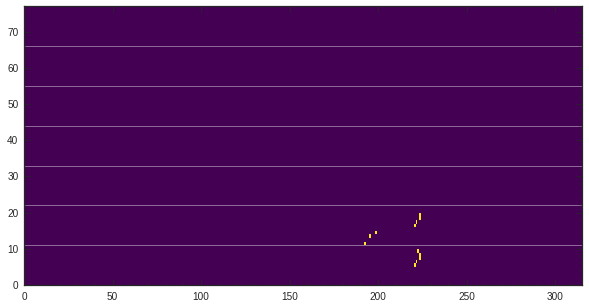

(array([ 5,  6,  7,  8,  9, 11, 13, 14, 16, 17, 18, 19]), array([220, 221, 223, 223, 222, 192, 195, 198, 220, 221, 223, 223]))


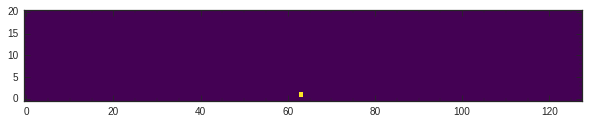

(array([1]), array([63]))


In [9]:
image = imaging(image_pixels[0], image_channels[0], superstrip_size=superstrip_size)
label = labeling(labels[0])
draw(image, label)

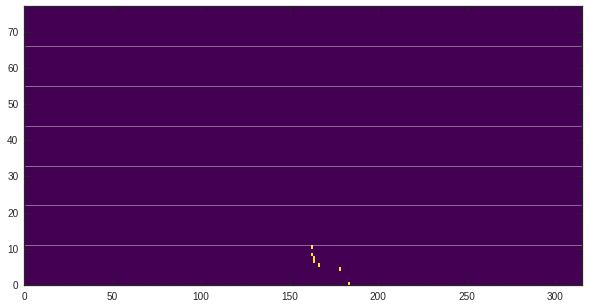

(array([ 0,  4,  5,  6,  7,  8, 10]), array([183, 178, 166, 163, 163, 162, 162]))


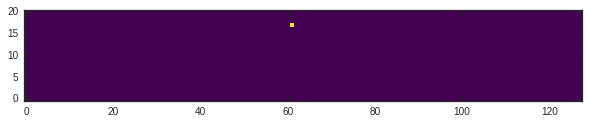

(array([17]), array([61]))


In [10]:
image = imaging(image_pixels[1], image_channels[1], superstrip_size=superstrip_size)
label = labeling(labels[1])
draw(image, label)

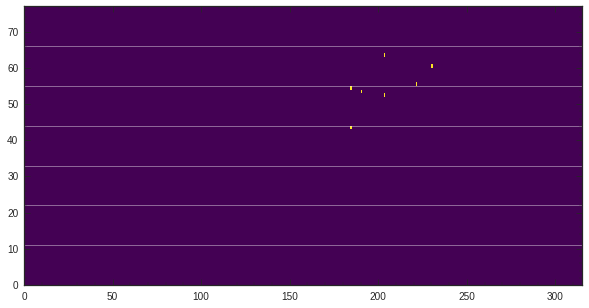

(array([43, 52, 53, 54, 55, 60, 63]), array([184, 203, 190, 184, 221, 230, 203]))


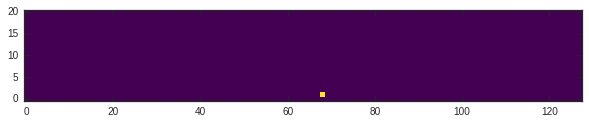

(array([1]), array([68]))


In [11]:
image = imaging(image_pixels[2], image_channels[2], superstrip_size=superstrip_size)
label = labeling(labels[2])
draw(image, label)

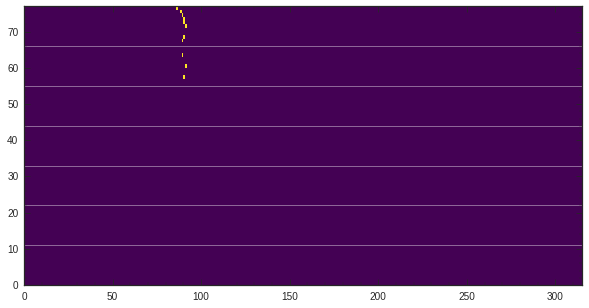

(array([57, 60, 63, 67, 68, 71, 72, 73, 74, 75, 76]), array([90, 91, 89, 89, 90, 91, 90, 90, 89, 88, 86]))


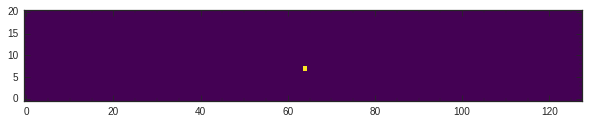

(array([7]), array([64]))


In [12]:
image = imaging(image_pixels[3], image_channels[3], superstrip_size=superstrip_size)
label = labeling(labels[3])
draw(image, label)

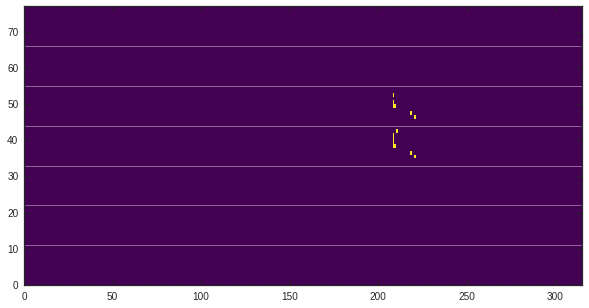

(array([35, 36, 38, 38, 39, 40, 41, 42, 46, 47, 49, 49, 50, 52]), array([220, 218, 208, 209, 208, 208, 208, 210, 220, 218, 208, 209, 208,
       208]))


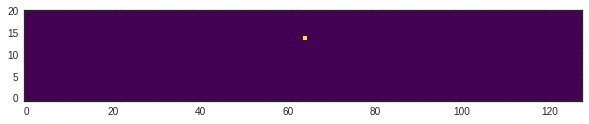

(array([14]), array([64]))


In [13]:
image = imaging(image_pixels[4], image_channels[4], superstrip_size=superstrip_size)
label = labeling(labels[4])
draw(image, label)

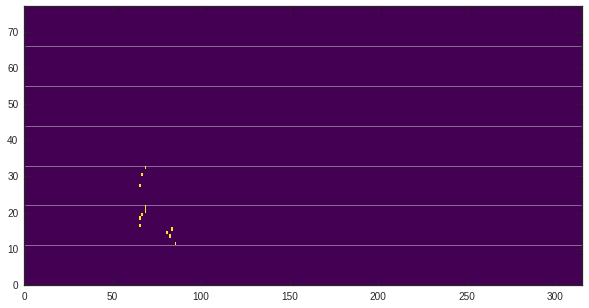

(array([11, 13, 14, 15, 16, 18, 19, 20, 21, 27, 30, 32]), array([85, 82, 80, 83, 65, 65, 66, 68, 68, 65, 66, 68]))


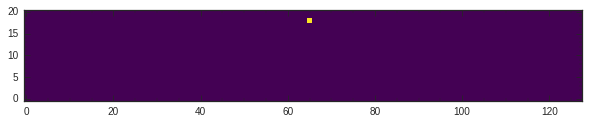

(array([18]), array([65]))


In [14]:
image = imaging(image_pixels[5], image_channels[5], superstrip_size=superstrip_size)
label = labeling(labels[5])
draw(image, label)